# Introduction
The goal of this notebook is to calibrate Monarch to match experimental baseline/acute volume overload data from Nakano et al. 1991. Subsequently, the fitted growth parameters from the calibration notebook will be utilized to predict the chronic MVR outcome. This notebook has two parts: 
1. Fitting the cardiac and hemodynamic parameters to match baseline (pre-MVR) and acute-MVR models
2. Validating growth parameters by predicting the chronic (post-MVR) response

In [1]:
import pathlib
import pandas as pd

# Get notebook directory and store everything in a subdirectory
root_dir = pathlib.Path().absolute()
data_dir = root_dir / "data_nakano"
baseline_dir = root_dir / "nakano_baselineacute"
growth_dir = root_dir / "nakano_growth"

# Import csv file data as pandas dataframe and first column as index
data_baseline = pd.read_csv(data_dir / "data_baselineacute.csv", index_col=0)

# Enable automatically reloading modules when they have changed
%load_ext autoreload
%autoreload 2

When rerunning this notebook, set the run_sims variable to false to skip the simulation step and only run the GPEs and implausibility calculations. Simulations ran previously will be loaded and this will tremendously speed up the process.

In [2]:
run_sims = True

We also set some constants that are used in the Monarch model. The hemodynamic ones come from the Kleaveland et al. 1988 paper, and the cardiac ratios are in the same as in the synthetic notebook.

In [3]:
# Model properties
input_file = root_dir.parent / "inputs" / "input_nakano"
model_constants = {"HR": 62, "HR_acute": 118, "AmRefRfwRatio": 1.36, "AmRefSwRatio": 0.53, "AmRefLARatio": 0.70,
                       "AmRefRARatio": 0.51, "RfWth": 3.4, "LAWth": 3.9, "RAWth": 3.9, "SWth": 10.3}

# Fitting the baseline model
## Setting up the Wave class
We will use the Wave class to fit the baseline/acute model. This class is designed to fit a model to a set of data points using Bayesian History Matching. First, we decide what parameters to fit and what their expected ranges are, and compile them in a list of dictionaries (one for each parameter). It is important that the labels match (case-insensitive) the label names in the monarch change_pars function.

In [4]:
pars = {
        "SAct": {"limits": [0.050, 0.200]},
        "AmRefLfw": {"limits": [4e3, 10e3]},
        "VLfw": {"limits": [40e3, 70e3]},
        "SBV": {"limits": [300, 1500]},
        "Ras": {"limits": [0.3, 5.0]},
        "SBV_acute": {"limits": [300, 1500]},
        "Ras_acute": {"limits": [0.3, 8.0]},
        "Rmvb_acute": {"limits": [0.05, 2.0]}
    }

## Running a full BHM scheme

We now run the entire BHM process, this will take several minutes, depending on your computer. Note that many simulation in the early waves will crash because some very unrealistic parameter sets are included, but in later waves the model will behave much better since only non-implausible parameters sets are retained.

In [5]:
from chameleon.camouflage import Camouflage
import chameleon.monarch_utils as model_utils

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True
sim_dirs = []

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)
    
    # Initialize wave    
    camo = Camouflage(i_wave, baseline_dir, wave_threshold, pars, data_baseline, nroy=nroy, clear_log=(i_wave == 0), 
                constants=model_constants)

    # Run simulations for all parameter sets in current wave set
    camo.x_sim, camo.y_sim, sim_dirs = model_utils.run_forest_run(camo, input_file, sim_dirs, constants=model_constants, 
                                                                  log_file=camo.log_file, run_sims=run_sims)

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    camo.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = camo.is_flooded(i_wave, min_waves=4, max_waves=5)
    nroy = camo.nroy
    i_wave += 1

-----------
Parameters:
-----------
- SAct: [0.05 - 0.2]
- AmRefLfw: [4000.0 - 10000.0]
- VLfw: [40000.0 - 70000.0]
- SBV: [300.0 - 1500.0]
- Ras: [0.3 - 5.0]
- SBV_acute: [300.0 - 1500.0]
- Ras_acute: [0.3 - 8.0]
- Rmvb_acute: [0.05 - 2.0]


-------------
Observations:
-------------
- LVEDV: 68.0 ± 6.8
- LVEF: 0.54 ± 0.03
- LVEDP: 5.7 ± 0.5
- SBP: 110.0 ± 4.6
- EDWthLfw: 8.1 ± 0.4
- LVEDV_acute: 83.0 ± 5.1
- LVEF_acute: 0.67 ± 0.023
- LVEDP_acute: 22.0 ± 1.5
- SBP_acute: 108.0 ± 7.1
- LVRF_acute: 0.62 ± 0.04


-------------
Constants:
-------------
- HR: 62
- HR_acute: 118
- AmRefRfwRatio: 1.36
- AmRefSwRatio: 0.53
- AmRefLARatio: 0.7
- AmRefRARatio: 0.51
- RfWth: 3.4
- LAWth: 3.9
- RAWth: 3.9
- SWth: 10.3



------
Wave 1
------
Generated emulation point cloud with 1048576 points
Running 128 model simulations...


/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/monarch/egg.py:137: RuntimeWarning: divide by zero encountered in divide
  self.volumes[0, :] = self.volumes[-1, :] * self.circulation.sbv / np.sum(self.volumes[-1, :])
/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/monarch/egg.py:137: RuntimeWarning: divide by zero encountered in divide
  self.volumes[0, :] = self.volumes[-1, :] * self.circulation.sbv / np.sum(self.volumes[-1, :])
/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-

128 simulation pairs (baseline + acute) completed in 19.85 seconds
119 Simulations reached convergence
92 Simulations added to training data
Training GPEs using PyTorch...
Emulating 1048576 points...
Emulation completed in 8.05 seconds
181738 points remaining in NROY region (17.33% of original space)
LVEDV is the most implausible output (25.67% of all points)
151416 points remaining in NROY region after limits check
NROY size change at Wave 1 is -0.86: no convergence

------
Wave 2
------
Running 128 model simulations...


/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)
/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/monarch/egg.py:137: RuntimeWarning: divide by zero encountered in divide
  self.volumes[0, :] = self.volumes[-1, :] * self.circulation.sbv / np.sum(self.volumes[-1, :])
/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/monarch/heart.py:304: RuntimeWar

128 simulation pairs (baseline + acute) completed in 21.01 seconds
123 Simulations reached convergence
105 Simulations added to training data
Training GPEs using PyTorch...
Emulating 151416 points...
Emulation completed in 1.42 seconds
3885 points remaining in NROY region (0.37% of original space)
LVEDP is the most implausible output (26.08% of all points)
3305 points remaining in NROY region after limits check
NROY size change at Wave 2 is -0.98: no convergence

------
Wave 3
------
Regenerating emulation cloud from 3305 to 100000 points...
Running 128 model simulations...


/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/monarch/egg.py:137: RuntimeWarning: divide by zero encountered in divide
  self.volumes[0, :] = self.volumes[-1, :] * self.circulation.sbv / np.sum(self.volumes[-1, :])


128 simulation pairs (baseline + acute) completed in 18.54 seconds
126 Simulations reached convergence
104 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 1.36 seconds
2397 points remaining in NROY region (0.23% of original space)
SBP is the most implausible output (18.57% of all points)
2397 points remaining in NROY region after limits check
NROY size change at Wave 3 is -0.27: no convergence

------
Wave 4
------
Regenerating emulation cloud from 2397 to 100000 points...
Running 128 model simulations...
128 simulation pairs (baseline + acute) completed in 17.51 seconds
128 Simulations reached convergence
114 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 1.95 seconds
1803 points remaining in NROY region (0.17% of original space)
SBP is the most implausible output (18.37% of all points)
1803 points remaining in NROY region after limits check
NROY siz

## Analyzing the results
Run and plot simulations using a randomly selected subset of the posterior distribution. Compare these results with the simulation results after we just ran the single wave with implausibility criterion of 5.0 to see the vast improvement.


---------
Posterior
---------
Running 256 model simulations...
256 simulation pairs (baseline + acute) completed in 29.21 seconds
256 Simulations reached convergence
239 Simulations added to training data


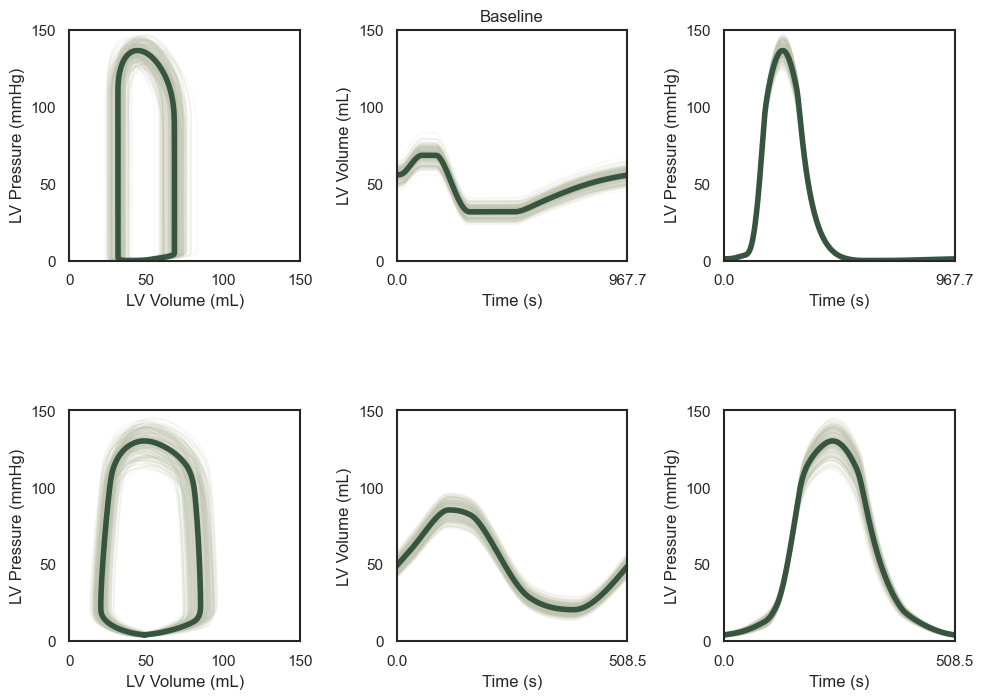

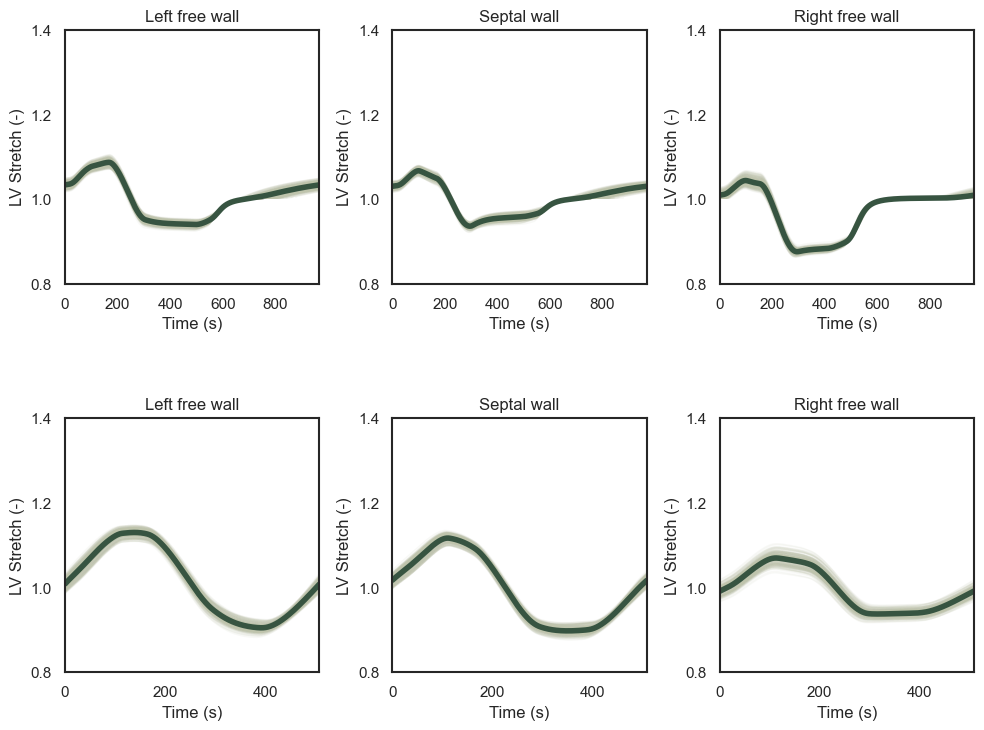

In [6]:
# Run simulations for all parameter sets in current wave set
x_posterior, y_posterior, _ = model_utils.run_forest_run(camo, input_file, [],  constants=model_constants, 
                                                         log_file=camo.log_file, show_fig=True, posterior=True)

In [7]:
camo.x_posterior, camo.y_posterior = x_posterior, y_posterior
camo.pickle_wave()

Now start the TrueColors class to further analyze the results. This class is designed to analyze the progression and final results of the fitting scheme. Because the Tide class is only dependent on the exported results from the Wave class, the following cell and all others in this section can be run independently of the rest of the notebook. First, always check if the final NROY region is within the 95% confidence interval of all data:

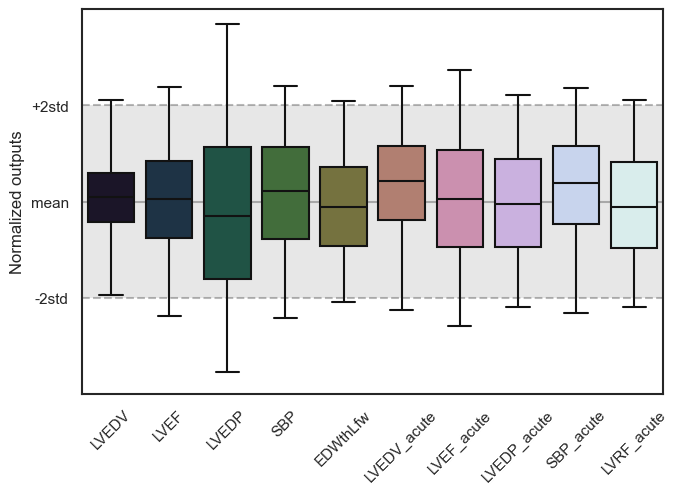

In [8]:
from chameleon.colors import TrueColors

colors = TrueColors(baseline_dir)

# Plot the convergence of the implausibility
colors.plot_nroy_data(show_violin = True)

Next, inspect the final NROY region to inspect if all parameters are uniquely fitted, and if the mean of the matched distribution is close to the true values in this synthetic case. This plot is time-consuming to generate, so we here run it with a subset of 1000 randomly chosen parameter sets.

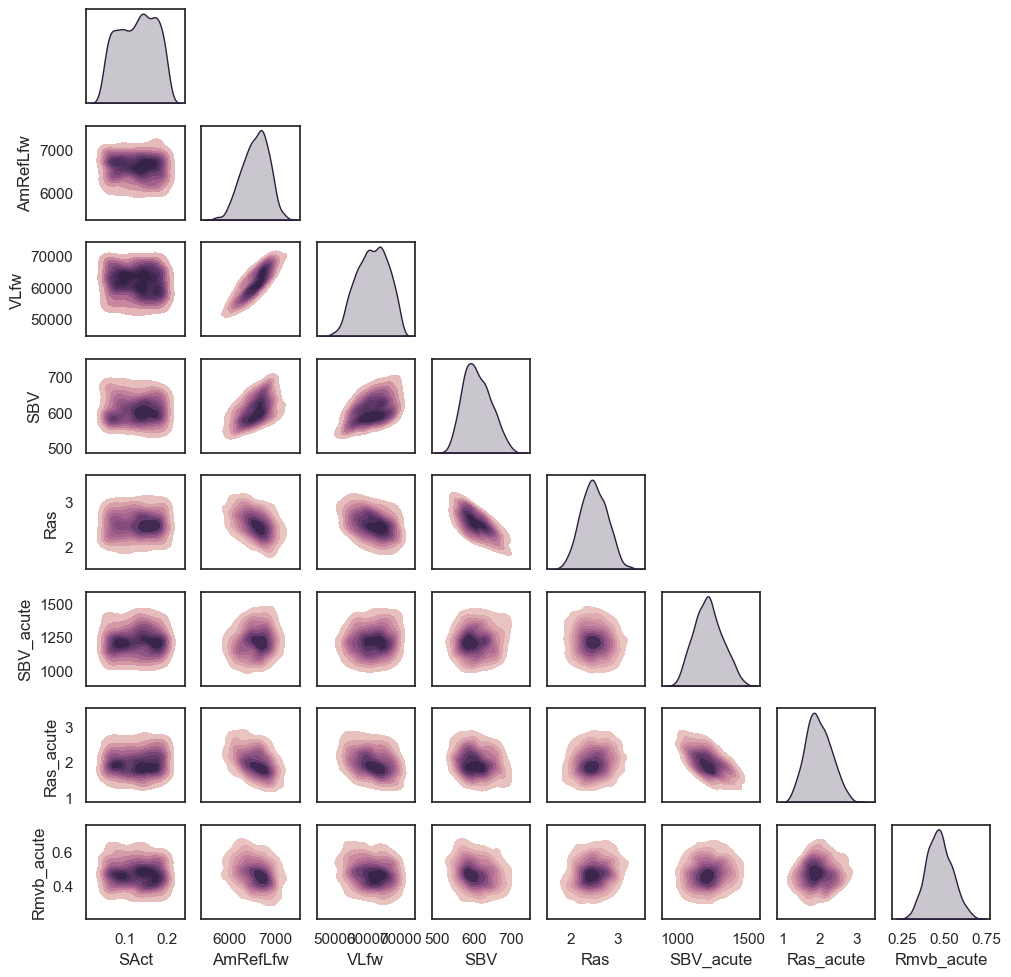

In [9]:
colors.plot_nroy_x(n_samples=1000, show_fig=True)

Run all plots, this will be time-consuming–in fact, it is slower than running BHM itself! The plots are saved in the *results* subdirectory.

In [10]:
import matplotlib.pyplot as plt
plt.close("all")
colors.roll(nroy_full=False)

# Validating the growth model
## Utilizing the previously calibrated growth model to predict growth in this study
Here we are updating the growth constants to match the growth model to the Nakano et al. 1991 data. We will then use the previously calibrated growth model to predict the chronic MVR outcome.

In [11]:
import numpy as np 
import pandas as pd

data = pd.read_csv(data_dir / "data_growth.csv", index_col=0)

model_constants.update(
                {"tau_f-": 1e5, "tau_r+": 1e5, "theta_f_max": 1.5 ** 2, "theta_f_min": 0.9 ** 2,
                 "gamma": 2.0, "theta_r_max": 1.5, "theta_r_min": 0.75, "t_mem": 1e5})
model_constants.update(
                {"theta_f_max": 1e5, "theta_f_min": 0,
                 "theta_r_max": 1e5, "theta_r_min": 0})

# Initialize wave
camo = Camouflage(0, growth_dir, 1, pars, data, nroy=nroy, clear_log=(i_wave == 0),
                    constants=model_constants, validation=True)


------
Wave 1
------
Regenerating emulation cloud from 21951 to 100000 points...


In [12]:
# Obtain the posterior distributions from the stored baseline and growth models
pickle_file_baseline = pathlib.Path(root_dir / 'nakano_baselineacute' / 'Wave 5' / 'wave.pkl')
pickle_file_growth = pathlib.Path(root_dir / 'kleaveland_growth' / 'Wave 5' / 'wave.pkl')

baseline = pd.read_pickle(pickle_file_baseline)
growth = pd.read_pickle(pickle_file_growth)

In [13]:
# Shuffle the posterior distributions and select the same number of samples for both models
growth_posterior = np.array(growth.x_posterior)
baseline_posterior = np.array(baseline.x_posterior)
np.random.shuffle(growth_posterior)
growth_posterior = growth_posterior[:len(baseline_posterior), :]
baseline_posterior = baseline_posterior[:len(growth_posterior), :]

num_pars = 2

camo.x_sim = np.append(baseline_posterior, growth_posterior[:, :num_pars], axis=1)
camo.x_names = np.append(baseline.x_names, growth.x_names[:num_pars])

# Run simulations for all parameter set pairs
camo.x_sim, camo.y_sim, sim_dirs = model_utils.run_forest_run(camo, input_file, sim_dirs,constants=model_constants,
                                                              log_file=camo.log_file, growth=True, run_sims=run_sims, remove_outliers=True, m_outlier=3)

Running 215 model simulations...
215 growth simulations completed in 80.18 seconds
215 Simulations reached convergence
171 Simulations added to training data


## Results export
The validation results will be within the sim_results subdirectory of Wave 1. 